### **ANN Streamflow Prediction**

*_Author: Aline Van Driessche_*

This notebook contains all code needed to reproduce the ANN training results on individual catchments (meteorological inputs available from Era5 and groundtruth streamflow from the NRFA). Read section headings for more details on setup, preprocessing, and model training.

#### Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [4]:
import os
import paths
import random
import torch
import warnings

import utils as ut
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.ticker as mtk

from tqdm import tqdm
from matplotlib import gridspec
from apollo import mechanics as ma
from apollo import streamflow as strf
from train_model import load_data, train
from preprocessing import catchment_characteristics as cc

warnings.filterwarnings('ignore')

### Experiment Variables

All variables that could be modified during the experiments. The features refer to the type of input variables that will be used for training and how many days in the past are included.

In [38]:
station = 33039

days = 6
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)]\
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']) 

years_train = [1980 + i for i in range(30)]
years_eval = [2010 + i for i in range(10)]

input_type = '9to9_HR_surf_interp' #others: {'linear', '9to9_cubic', '9to9_surf_interp' ...}

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Loading and Processing Relevant Data

Data loading function that extracts and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. The initial catchment information (shapefile catchment boundary etc) are downloaded from the *https://nrfa.ceh.ac.uk/* website. For reproduction, also the river streamflow can be obtained from the *https://nrfa.ceh.ac.uk/* website, and the meteorological input variables through the Coopernicus CDS API, *https://cds.climate.copernicus.eu/*. The input variables are preprocessed in the correct manner after running 'assembly.py'. 

In [39]:
# General information
general_info_df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))

In [53]:
# In- and output variables
original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + f"_lumped_{input_type}.csv"))
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
clean_data = original_data.dropna(subset=['Flow'])
print(len(original_data) - len(clean_data), 'riverflow values are missing.')

0 riverflow values are missing.


In [54]:
rain = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
rows_with_nan = clean_data[clean_data.isna().any(axis=1)]
rows_with_nan

,Unnamed: 0.1,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,...,Rain-18.1,Rain-19.1,Rain-20.1,Rain-21.1,Rain-22.1,Rain-23.1,Rain-24.1,Rain-25.1,Rain-26.1,Rain-27.1
0,0,209,1979-07-29,3.43,291.877568,4.546481,2.306659,80.955953,0.0,5.098153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,210,1979-07-30,4.85,290.900632,4.224677,3.149402,67.309024,0.0,5.269405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,211,1979-07-31,5.24,289.821162,6.280046,1.859816,50.859116,0.0,6.549649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,212,1979-08-01,4.85,291.123053,5.753759,2.031156,54.989641,0.0,6.101749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,213,1979-08-02,4.08,290.236948,4.729272,1.841669,67.792017,0.0,5.075210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813,2813,3095,1987-06-23,13.80,287.056150,1.884015,1.865235,76.028545,0.0,2.651153,...,5.254412,5.919984,3.894300,9.455644,1.121056,1.290541,2.414412,1.112131,2.134505,0.009135
2814,2814,3096,1987-06-24,12.00,287.049566,5.756564,-5.060555,60.901467,0.0,7.664675,...,5.436153,5.254412,5.919984,3.894300,9.455644,1.121056,1.290541,2.414412,1.112131,2.134505
2815,2815,3097,1987-06-25,13.00,287.039412,2.733323,3.213758,91.909290,0.0,4.218921,...,1.775714,5.436153,5.254412,5.919984,3.894300,9.455644,1.121056,1.290541,2.414412,1.112131
2816,2816,3098,1987-06-26,19.70,288.758468,1.721937,0.769816,78.827125,0.0,1.886182,...,15.200284,1.775714,5.436153,5.254412,5.919984,3.894300,9.455644,1.121056,1.290541,2.414412


#### Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We use a neural network training using the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our three metrics (RMSE, NSE, RE) are then calculated.

In [50]:
def train_NN(rf, years_train, years_eval, features=features, loss_func=None, alpha=1.0, beta=1.0, grid_search=False, early_stopping=True, verbose=True):

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval, years_train)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   
    
    psi = ut.psi_distribution(y_train, alpha=alpha, beta=beta, plot=False)

    # TRAINING
    network = train.train(x_train, 
                          y_train,
                          verbose=verbose, 
                          loss_func_type=loss_func, 
                          psi=psi[:len(x_train)], 
                          grid_search=grid_search, 
                          early_stopping=early_stopping)

    # EVALUATION
    x_eval = load_data.reshape_input(full_set, xspace)  
    y_eval = load_data.reshape_input(full_set, yspace)  
    
    rf.loc[:, 'Predicted'] = network.predict(torch.from_numpy(x_eval).to(device))
    rf.loc[:, 'Groundtruth'] = y_eval    
    rf['Date'] =  pd.to_datetime(rf['Date'], unit='s')
    rf = rf[rf['Date'].dt.year.isin(years_train + years_eval)]
    rf.reset_index(drop=True, inplace=True)
    return rf, network

#### Experiment 1

Run the standard NN on a single catchment and calculate the performance.

2024-06-23 02:09:19.924 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.000632)
2024-06-23 02:09:20.148 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.003843)


epoch 0, loss 335.8731384277344
epoch 500, loss 65.04512023925781
epoch 1000, loss 59.10667419433594
epoch 1500, loss 55.76231002807617
epoch 2000, loss 54.25502014160156
epoch 2500, loss 52.09724044799805
epoch 3000, loss 51.224796295166016
epoch 3500, loss 50.79793167114258
epoch 4000, loss 50.460628509521484
epoch 4500, loss 50.36664962768555
epoch 5000, loss 50.274070739746094
Early stopping at epoch 5480, best validation loss: 48.376930236816406


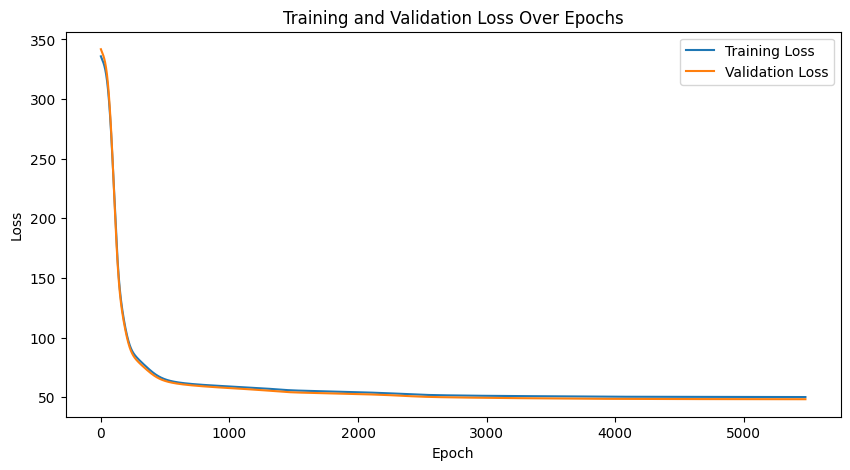

In [51]:
outdf, _ = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None,alpha=1, beta=2, grid_search=False,verbose=True) 

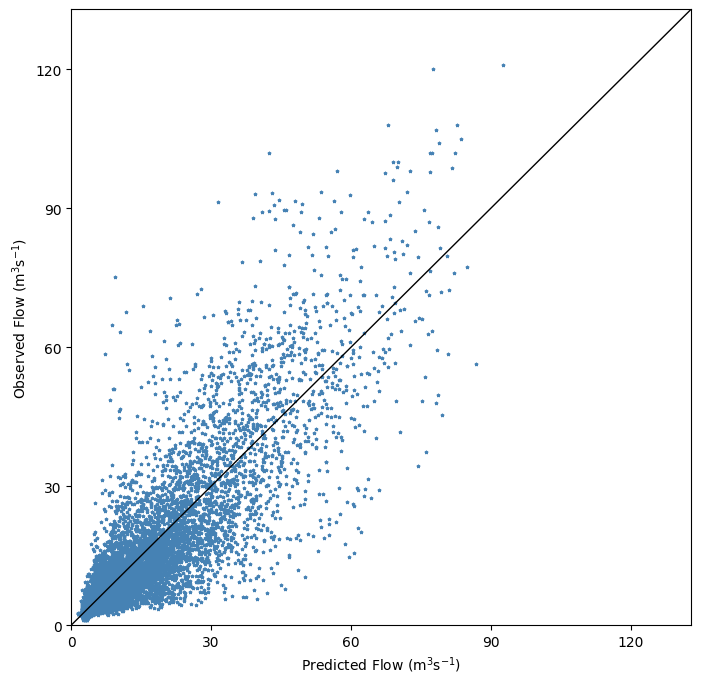

RMSE: 7.049698047160858
NSE: 0.7397572216472268
RE: 0.9364403677393229


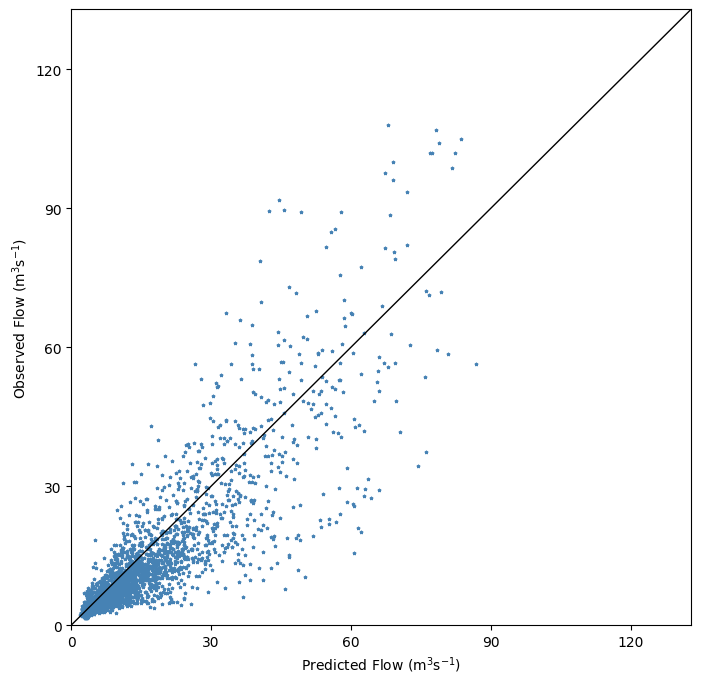

RMSE: 6.984792668286563
NSE: 0.7281712835284688
RE: 0.9218263710151535


In [52]:
# Plot the network performance
for test_period in (years_train+years_eval, years_eval):
     
    performance_dict = train.calculate_performance_metrics(outdf, test_period) 

    print('RMSE: ' + str(performance_dict.get('RMSE')))
    print('NSE: ' + str(performance_dict.get('NSE')))
    print('RE: ' + str(performance_dict.get('RE')))

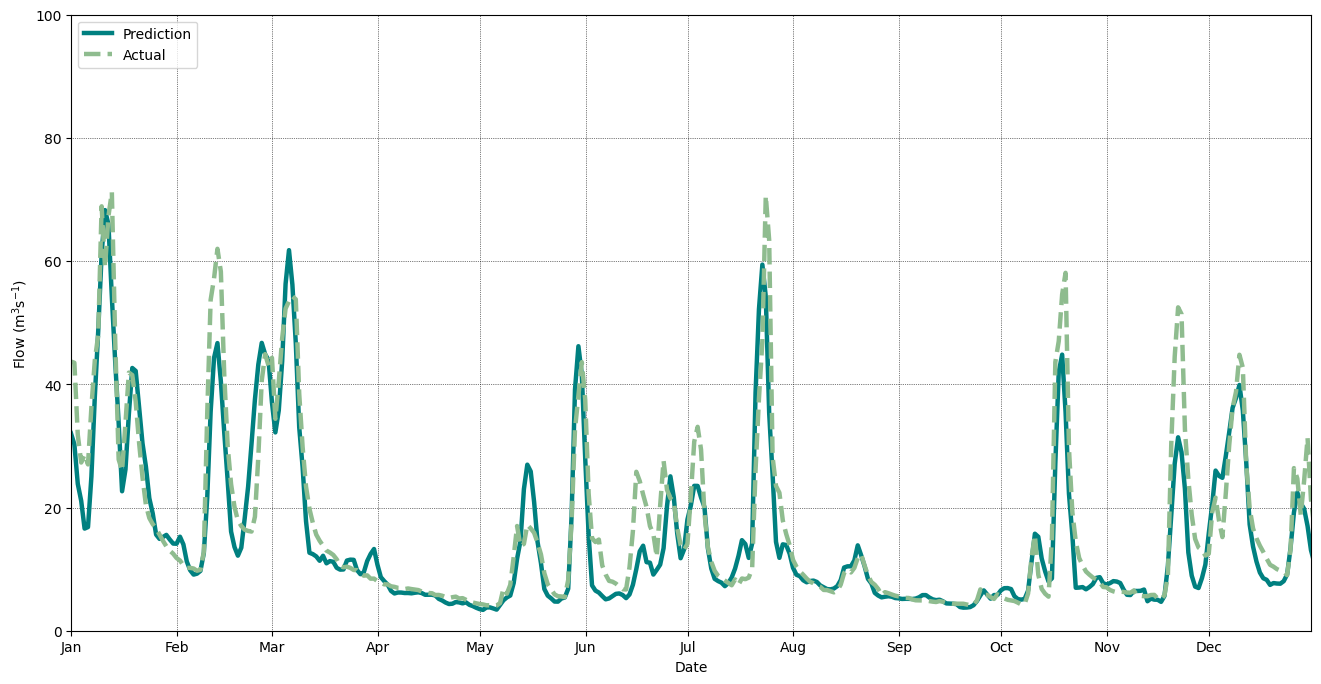

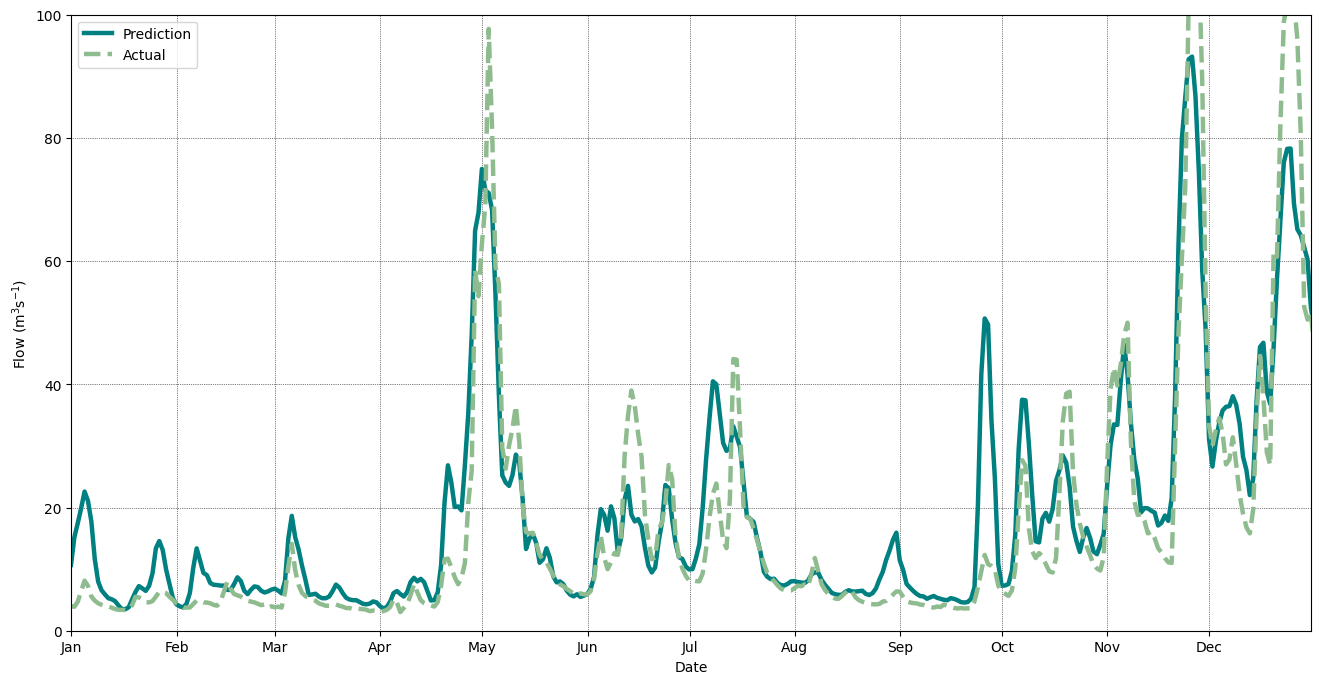

In [32]:
# Plot the visual performance for selected years
strf.year_plot(outdf, 'Predicted', 'Flow', 2007)
strf.year_plot(outdf, 'Predicted', 'Flow', 2012) 

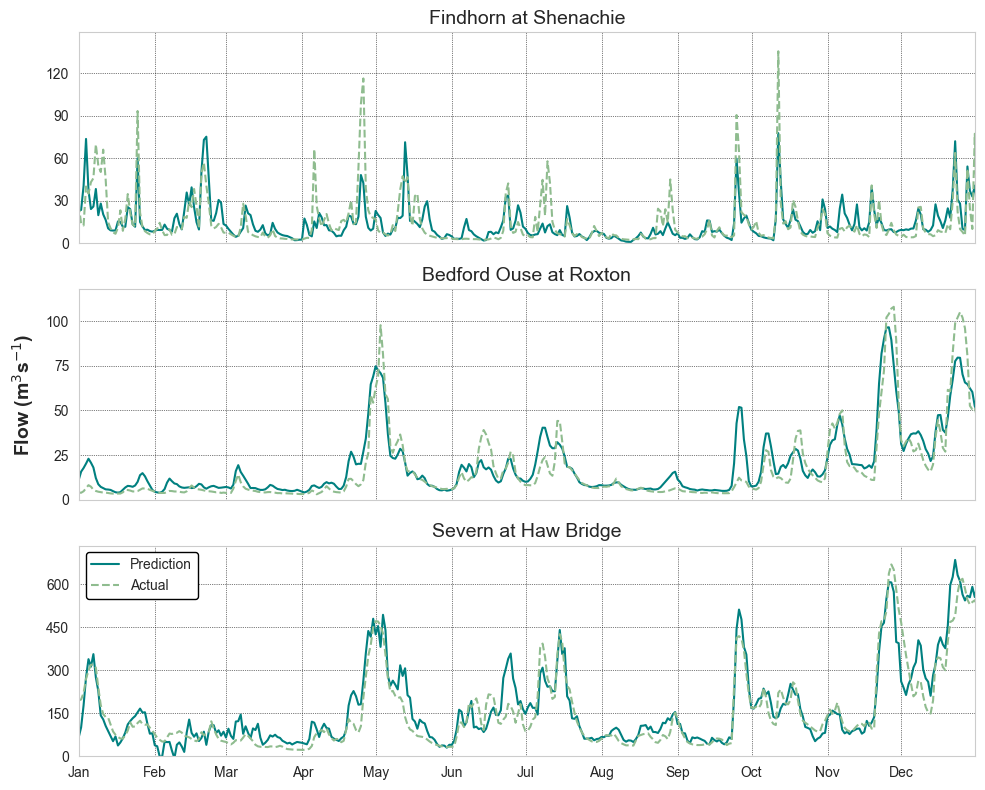

In [445]:
# PLOT performance for 1 year across the 3 most important sites
stations = ['7001', '33039', '54057']
titles = ['Findhorn at Shenachie', 'Bedford Ouse at Roxton', 'Severn at Haw Bridge']

fig, ax = plt.subplots(len(stations), figsize=(10, 8), sharex=True)

colour1 = 'Teal'
colour2 = 'darkseagreen'

year = 2012

for i, station in enumerate(stations):
    
    catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(station) + '.shp')
    
    original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(station) + f"_lumped_{input_type}.csv")
    original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
    clean_data = original_data.dropna(subset=['Flow'])
    
    outdf, _ = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None, alpha=1, beta=2, grid_search=False, verbose=False)
    
    maxflow = int(1.1 * max(np.array(outdf[outdf['Date'].dt.year.isin([year])]['Groundtruth'])))
    
    ax[i].plot(outdf['Date'], outdf['Predicted'], colour1, lw=1.5, label='Prediction')
    ax[i].plot(outdf['Date'], outdf['Groundtruth'], colour2, lw=1.5, ls='--', label='Actual')
    
    ax[i].set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
    ax[i].set_ylim(0, maxflow)
    ax[i].grid(c='black', ls='dotted', lw=0.5)
    ax[i].margins(x=0, y=0)

    if i == len(stations) - 1:
        ax[i].legend(loc='upper left', edgecolor='black', framealpha=1)

    ax[i].set_title(titles[i], size=14)
    ax[i].xaxis.set_major_locator(mdt.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    ax[i].yaxis.set_major_locator(mtk.MaxNLocator(5))

# Labeling the y-axis
fig.supylabel('Flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')', weight='bold', size=14)

# Spacing
plt.tight_layout()
plt.savefig(f'{paths.IMAGES}/stacked_riverflow_performances.png', dpi=300, bbox_inches='tight')
plt.show()

#### Experiment 2

Calculate the mean performance metrics on the 3 individual catchments based on a k-fold cross-validation. Training is similar as before, except that the training/test split is carried out randomly instead of based on fixed (chronological) periods of time.

In [468]:
total_years = [1980 + i for i in range(40)]
k_folds = 5

In [469]:
performance_metrics = []
for i in tqdm(range(k_folds), desc="K-Fold Progress"):
    
    years_eval = random.sample(total_years, 10)
    years_train = [year for year in total_years if year not in years_eval]
    
    outdf, _ = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None,alpha=1, beta=2, grid_search=False,verbose=False) 
    
    performance_dict = train.calculate_performance_metrics(outdf, years_eval, plot=False) 
    performance_metrics.append(performance_dict)
    
performance_df = pd.DataFrame(performance_metrics)
mean_performance = performance_df.mean()
mean_performance

K-Fold Progress: 100%|██████████| 5/5 [06:03<00:00, 72.67s/it]


RMSE    49.215488
NSE      0.816639
RE       0.925629
dtype: float64

#### Experiment 3

Expand across 25 other UK catchments. The descriptions for all these catchments are defined in 'Catchment_Database.csv', where station number, station name, flow file, boundary file ... are defined per catchment. All this information has been retrieved from the *https://nrfa.ceh.ac.uk/* website. The model predictions are stored for each catchment individually. Based on these performances, the NSE for each catchment is calculated, as a comparative metric. Other catchment characteristics (hydrological efficiency, slope gradient, latitude ..) are deduced from the previously obtained data (flow & geographical boundaries) from NRFA. These characteristics are then used to plot the correlation with the model performance in each catchment.

In [166]:
## MODEL TRAINING + PREDICTIONS

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS), desc="Processing Stations"):
    
    out_path = '../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}.csv"
    
    if not os.path.exists(out_path):
        catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + '.shp')
    
        original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + f"_lumped_{input_type}.csv")
        original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
        clean_data = original_data.dropna(subset=['Flow'])
    
        outdf, _ = train_NN(rf=clean_data, years_train=years_train, years_eval=years_eval, features=features, loss_func=None, alpha=1, beta=2, grid_search=False, verbose=False)
        outdf.to_csv(out_path)

Processing Stations: 100%|██████████| 26/26 [00:00<00:00, 25804.99it/s]


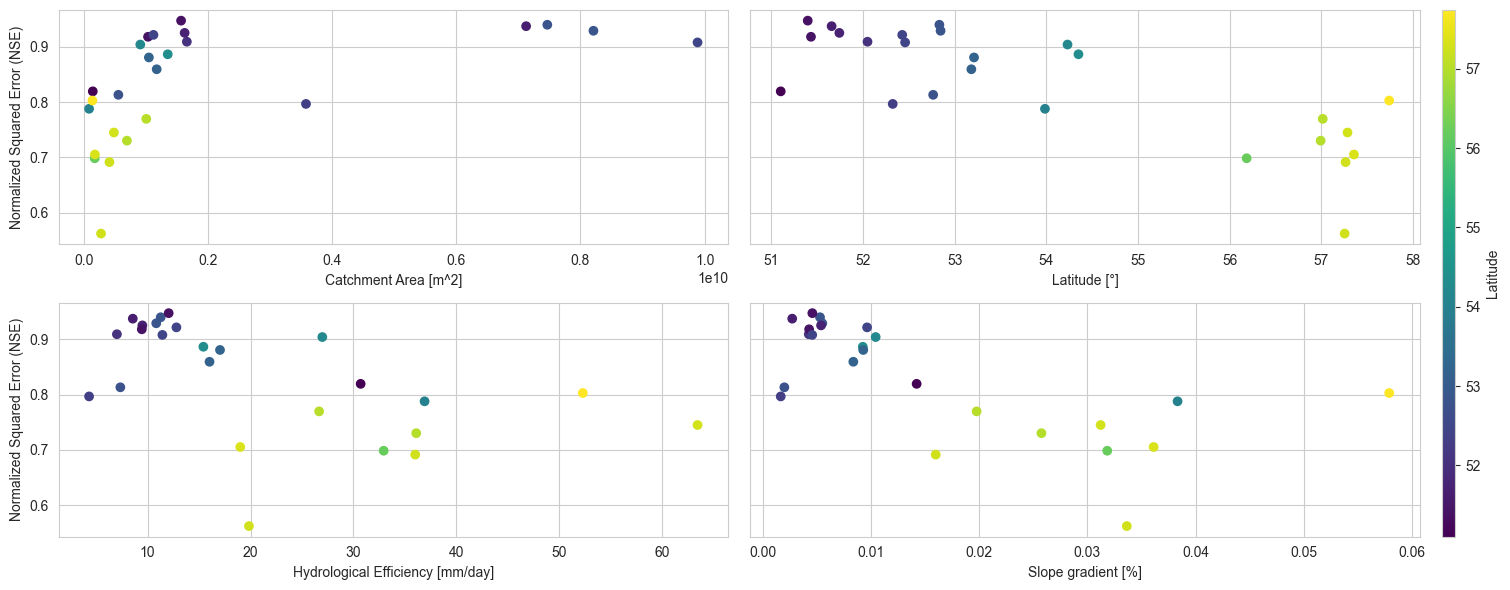

In [231]:
## PERFORMANCE PLOT

input_type = '9to9_linear'

overview_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type=input_type, 
                                                   years_eval=years_eval)

params_to_plot = ['Area', 'Latitude', 'HE_mean', 'Slope gradient']
labels_to_plot = ['Catchment Area [m^2]', 'Latitude [°]', 'Hydrological Efficiency [mm/day]', 'Slope gradient [%]']

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.02])
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(overview_gdf['Latitude'].min(), overview_gdf['Latitude'].max())

# Plot each parameter in its respective subplot
for i, param in enumerate(params_to_plot):
    if i < 4:
        sc = axes[i].scatter(overview_gdf[param], overview_gdf['NSE'], c=overview_gdf['Latitude'], cmap=cmap, norm=norm, marker='o')
        axes[i].set_xlabel(labels_to_plot[i])
        if i == 0 or i == 2:
            axes[i].set_ylabel('Normalized Squared Error (NSE)')
        else:
            axes[i].set_yticklabels([])
        
        # Add station names next to each dot
        #for j, row in overview_gdf.iterrows():
            #axes[i].text(row[param], row['NSE'], row['Station'], fontsize=8, ha='left')
        
        axes[i].grid(True)

# Add colorbar to indicate latitude
cax = fig.add_subplot(gs[:, 2]) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='vertical', label='Latitude')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(f"{paths.IMAGES}/cross_catchments_comparison_{input_type}.png", dpi=300, bbox_inches='tight')
plt.show()